# Bayesian methods for machine learning - Week 2

In [2]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from graphviz import Digraph

from mixture import (
    sample_mixture,
    sample_data
)

from visualization import plot_data

## Gaussian Mixture Models (GMM)

### Introduction

Gaussian Mixture models are a flexible ways to approximate continuous densities as a linear combination of individual Gaussian components. Note that any arbitrary density can be fairly approximated using enough components and the fitted parameters. The marginal density of a point $\pmb{x}$ can be modelled as:

$$
\begin{align*}
P(\pmb{x}) & = \sum_{k=1}^K P(k) P(\pmb{x}|k) \\
     & = \sum_{k=1}^K \pi_k \mathcal{N}(\pmb{x}| \pmb{\mu_k}, \pmb{\Sigma_k})
\end{align*}
$$

Where each Gaussian density $\mathcal{N}(\pmb{x}| \pmb{\mu_k}, \pmb{\Sigma_k})$ is a component out of the $K$ components in the mixture and $\pi_k$ are mixture coefficients. A multivariate Gaussian distribution is centered at each component and, given a certain data point, a high density for a specific Gaussian means that the point highly relates to that cluster. Note that mixtures can be of any kind of distribution, but here we are focused on Mixtures of Gaussian densities.

Mixture coefficients $\pi_k$ must satisfy two constraints:

- Sum over all coefficients must be one:

$$
\begin{align*}
\int P(\pmb{x}) \ d\pmb{x} & = \int \sum^K_{k=1} \pi_k \mathcal{N}(\pmb{x} | \pmb{\mu_k}, \pmb{\Sigma_k}) \ d\pmb{x}\\
1 & = \sum^K_{k=1} \pi_k  \int \mathcal{N}(\pmb{x}| \pmb{\mu_k}, \pmb{\Sigma_k}) \ d\pmb{x}\\
1 & = \sum^K_{k=1} \pi_k \\
\end{align*}
$$

- They must be in interval $[0, 1]$.

Therefore, they can be conceived as a probability distribution over the components.

### Probabilistic approach

We introduce a latent binary variable $\pmb{z} \in \mathcal{R}^{K}$ representing the belonging of each data point to the corresponding mixture component. For each instance $\pmb{x_i} \in \mathcal{R}^{d}$ we have the corresponding latent variable $\pmb{z_i}$.

Where $P(\pmb{z})$ can be expressed as:

$$
P(z_k = 1) = \pi_k
$$

And:

$$
P(\pmb{x}| \pmb{z_k} = 1) = \mathcal{N}(\pmb{x} | \pmb{\mu_k}, \pmb{\Sigma_k})
$$

The joint distribution is defined as:

$$
P(\pmb{x}, \pmb{z}) = P(\pmb{z}) P(\pmb{x}|\pmb{z})
$$

We can obtain marginal of $x$ through summing over all possible values of $z$ in the joint distribution:

$$
P(\pmb{x}) = \sum_z P(Z = z_k)P(\pmb{x}|Z) = \sum_z \pi_z \mathcal{N}(\pmb{x}| \pmb{\mu_k}, \pmb{\Sigma_k})
$$

Given the set of parameters $\theta = \{ \pi_1, \pmb{\mu_1}, \pmb{\Sigma_1}, \ldots, \pi_K, \pmb{\mu_K}, \pmb{\Sigma_K} \}$, a set of i.i.d observations $\pmb{X} = \{\pmb{x_1}, \pmb{x_2}, \ldots, \pmb{x_N}\}$ and the corresponding latent variables $\pmb{Z} = \{ \pmb{z_1}, \pmb{z_2}, \ldots, \pmb{z_N} \}$, the likelihood[<sup>1</sup>](#fn2) of the data under the parameters is computed as:

$$
P(\pmb{X}|\theta) = \prod^N_{i=1} \sum^K_{k=1} \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})
$$

<hr>
<span id="fn1">[1] As a recap, note that the likelihood $P(\pmb{X}|\theta)$ is not a probability distribution, as data is fixed.</span> <br>
<hr>

The resulting graphical model can be viewed as:

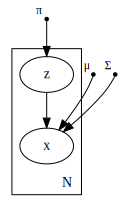

In [4]:
plate_nb = Digraph()

plate_nb.node('P', xlabel='<<font point-size="12">&pi;</font>>', shape='point')
plate_nb.node('M', xlabel='<<font point-size="12">&mu;</font>>', shape='point')
plate_nb.node('S', xlabel='<<font point-size="12">&Sigma;</font>>', shape='point')

with plate_nb.subgraph(name='cluster') as plate:
    plate.node('x')
    plate.node('z')
    plate.attr(label='N', labeljust='r', labelloc='b')
    plate.edge('z', 'x')

plate_nb.edge('P', 'z')
plate_nb.edge('M', 'x')
plate_nb.edge('S', 'x')
    
plate_nb

### Estimating the parameters 

Recall that the likelihood of the data is computed as:

$$
P(\pmb{X}|\theta) = \prod^N_{i=1} \sum^K_{k=1} \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})
$$

We could estimate the parameters through maximum likelihood estimation:

$$
\begin{align} \\
\theta_{MLE} & = \underset{\theta}{\mathrm{argmax}} P(\pmb{X}| \theta) \\
             & = \underset{\theta}{\mathrm{argmax}} \prod_i^N P(\pmb{x_i}| \theta) \\
             & = \underset{\theta}{\mathrm{argmax}} \prod_i^N \sum_k^K \pi_k \mathcal{N}(\pmb{x_i}|\pmb{\mu_k}, \pmb{\Sigma_k})
\end{align}
$$

Note that maximizing the log likelihood of the data is easier to handle:

$$
\begin{align} \\
\theta_{MLE} & = \underset{\theta}{\mathrm{argmax}} \log \prod_i^N \sum_k^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k) \\
         & = \underset{\theta}{\mathrm{argmax}} \sum_i^N \log \left[ \sum_k^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k) \right]
\end{align}
$$

Recall the following constraints must be satisfied for $\pi_k$:

- $\sum_i^M \pi_i = 1$
- $\pi_i \ge 0, \forall i = 1 \ldots M$

We see there is a problem in the maximization, as we encounter a log of a sum; the previous expression does not have a closed-form solution. We can maximize it by:

- Using numerical optimization.
- Through expectation-maximization algorithm (EM).

By fitting the data, we will obtain the parameters enabling to classify new points into clusters. 

## Generating GMM data

Let's create random Gaussian mixture components. As we will know the generating distribution, we can compute the groundtruth likelihood straightforward. We make sure covariance matrices are invertible by sampling positive semi-definite matrices. Once we have the mixture components, we can proceed to sample examples.

### Sampling from a GMM

To sample $\pmb{x_i}$, we follow two steps:

1. Sample $\pmb{z}$ from categorical distributions determined by priors $\pi_i$.
1. Given $z_i = k$, sample $\pmb{x_i}$ from $k$th mixture component and label it as cluster $k$.

Let's take a look at the problem will be working on:

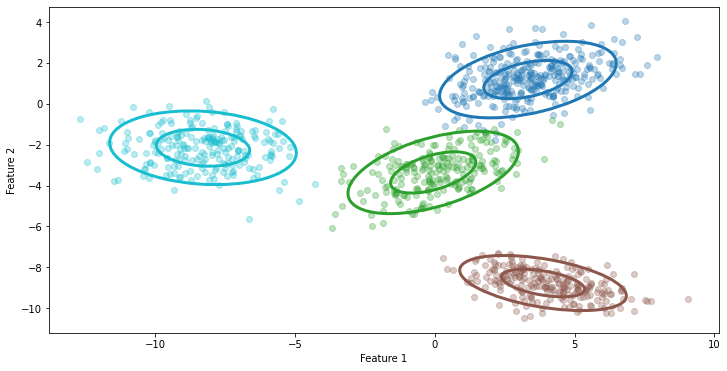

In [3]:
true_mus, true_sigmas, true_coefs = sample_mixture()
X, y = sample_data(mus=true_mus,
                   sigmas=true_sigmas,
                   coefs=true_coefs)

# Show data
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()

plot_data(X=X,
          y=y,
          mus=true_mus,
          sigmas=true_sigmas,
          ax=ax)

In the next notebooks we will try to fit the Mixtures using both optimization and Expectation Maximization.

## References

This and following Gaussian Mixture notebooks are based on the following links.

Followed Chapter 9 in Machine Learning and Pattern Recognition from [Bishop's book](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).
                                                                     
Other important support material:

- [Explanation on Lagrange Multipliers](https://bjlkeng.github.io/posts/lagrange-multipliers/)
- [Notes on Gaussian Mixture Models](http://www.cs.rpi.edu/~stewart/sltcv/handout-04.pdf)
- [Notes on Gaussian Mixture Models (Cambridge)](http://mi.eng.cam.ac.uk/~pcw/local/4F10/lect3.pdf)
- [Notes on Gaussian Mixture Models (Berkeley)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter13.pdf)
- [Stack exchange: derivative od matrix determinant](https://math.stackexchange.com/questions/1981210/what-is-the-derivative-of-the-determinant-of-a-symmetric-positive-definite-matri)
- [The Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)